In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
FILE_NAME = 'NIfty50.csv'

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime

%load_ext tensorboard
print(tf.version.VERSION)

2.11.0


In [3]:
# split dataset 80% train, 15% validation, 5% dev
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = size * 15 // 100
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minute")
    plt.ylabel("Price")
    plt.grid(True)

def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

def get_metrics_result(metrics, true_labels, predicted_labels):    
    metrics_result = []
    for metric in metrics:
        metric.reset_states()
        metric.update_state(true_labels, predicted_labels)
        metrics_result.append(metric.result().numpy())
    
    return metrics_result

In [4]:
data = pd.read_csv(FILE_NAME, sep=',')
data.head()

,Date,Index,Open,High,Low,Close,Volume,Currency
0,01-01-1997,NIFTY 50,905.20,941.40,905.20,939.55,38948000,INR
1,02-01-1997,NIFTY 50,941.95,944.00,925.05,927.05,49118000,INR
2,03-01-1997,NIFTY 50,924.30,932.60,919.55,931.65,35264000,INR
3,06-01-1997,NIFTY 50,932.45,937.95,925.65,927.80,26324000,INR
4,07-01-1997,NIFTY 50,926.35,935.15,922.25,928.80,44473000,INR


In [5]:
df1=data.reset_index()['Close']

In [6]:
df1

0         939.55
1         927.05
2         931.65
3         927.80
4         928.80
          ...   
6236    17149.10
6237    17277.95
6238    17110.15
6239    17101.95
6240    17316.65
Name: Close, Length: 6241, dtype: float64

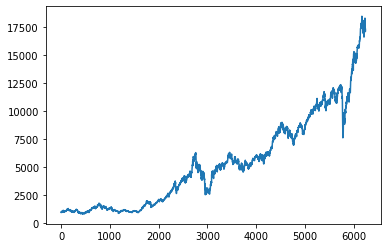

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
print(df1)

[[0.0074059 ]
 [0.00669842]
 [0.00695877]
 ...
 [0.92263567]
 [0.92217157]
 [0.93432324]]


In [10]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(4056, 2185)

In [12]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [13]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
print(X_train.shape), print(y_train.shape)

(3955, 100)
(3955,)


(None, None)

In [15]:
print(X_test.shape), print(ytest.shape)

(2084, 100)
(2084,)


(None, None)

In [16]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [17]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=15,batch_size=64,verbose=1)


Epoch 1/15
62/62 [==============================] - 30s 391ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/15
62/62 [==============================] - 19s 308ms/step - loss: 9.0247e-05 - val_loss: 0.0018
Epoch 3/15
62/62 [==============================] - 18s 298ms/step - loss: 8.2323e-05 - val_loss: 0.0025
Epoch 4/15
62/62 [==============================] - 19s 304ms/step - loss: 7.8685e-05 - val_loss: 0.0030
Epoch 5/15
62/62 [==============================] - 20s 319ms/step - loss: 7.4218e-05 - val_loss: 0.0029
Epoch 6/15
62/62 [==============================] - 15s 236ms/step - loss: 7.3305e-05 - val_loss: 0.0025
Epoch 7/15
62/62 [==============================] - 20s 324ms/step - loss: 6.7003e-05 - val_loss: 0.0029
Epoch 8/15
62/62 [==============================] - 20s 319ms/step - loss: 6.4431e-05 - val_loss: 0.0027
Epoch 9/15
62/62 [==============================] - 16s 253ms/step - loss: 6.1149e-05 - val_loss: 0.0025
Epoch 10/15
62/62 [==============================] - 19s 30

In [27]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
62/62 [==============================] - 14s 231ms/step - loss: 4.9531e-05 - val_loss: 0.0014
Epoch 2/20
62/62 [==============================] - 15s 245ms/step - loss: 4.9859e-05 - val_loss: 0.0012
Epoch 3/20
62/62 [==============================] - 14s 224ms/step - loss: 4.5007e-05 - val_loss: 8.0934e-04
Epoch 4/20
62/62 [==============================] - 14s 228ms/step - loss: 4.2129e-05 - val_loss: 0.0011
Epoch 5/20
62/62 [==============================] - 14s 228ms/step - loss: 4.2299e-05 - val_loss: 0.0013
Epoch 6/20
62/62 [==============================] - 18s 285ms/step - loss: 4.8829e-05 - val_loss: 0.0013
Epoch 7/20
62/62 [==============================] - 20s 318ms/step - loss: 4.1793e-05 - val_loss: 9.1658e-04
Epoch 8/20
62/62 [==============================] - 15s 251ms/step - loss: 3.9933e-05 - val_loss: 0.0017
Epoch 9/20
62/62 [==============================] - 15s 246ms/step - loss: 4.8504e-05 - val_loss: 5.5619e-04
Epoch 10/20
62/62 [========================

In [34]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=30,batch_size=64,verbose=1)

Epoch 1/30
62/62 [==============================] - 14s 229ms/step - loss: 3.0985e-05 - val_loss: 7.1177e-04
Epoch 2/30
62/62 [==============================] - 17s 272ms/step - loss: 3.4037e-05 - val_loss: 4.9684e-04
Epoch 3/30
62/62 [==============================] - 15s 241ms/step - loss: 3.3013e-05 - val_loss: 7.0230e-04
Epoch 4/30
62/62 [==============================] - 15s 240ms/step - loss: 3.2726e-05 - val_loss: 4.5688e-04
Epoch 5/30
62/62 [==============================] - 15s 247ms/step - loss: 2.9113e-05 - val_loss: 7.0499e-04
Epoch 6/30
62/62 [==============================] - 15s 251ms/step - loss: 2.9576e-05 - val_loss: 7.3530e-04
Epoch 7/30
62/62 [==============================] - 15s 249ms/step - loss: 2.8639e-05 - val_loss: 0.0011
Epoch 8/30
62/62 [==============================] - 18s 287ms/step - loss: 2.7693e-05 - val_loss: 3.2717e-04
Epoch 9/30
62/62 [==============================] - 15s 248ms/step - loss: 2.8096e-05 - val_loss: 3.5942e-04
Epoch 10/30
62/62 [====

In [41]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=40,batch_size=64,verbose=1)

Epoch 1/40
62/62 [==============================] - 18s 275ms/step - loss: 1.3021e-05 - val_loss: 2.0661e-04
Epoch 2/40
62/62 [==============================] - 16s 265ms/step - loss: 1.2356e-05 - val_loss: 9.7219e-05
Epoch 3/40
62/62 [==============================] - 16s 264ms/step - loss: 1.2916e-05 - val_loss: 4.0943e-04
Epoch 4/40
62/62 [==============================] - 17s 270ms/step - loss: 1.5201e-05 - val_loss: 2.0383e-04
Epoch 5/40
62/62 [==============================] - 16s 266ms/step - loss: 1.3342e-05 - val_loss: 1.4835e-04
Epoch 6/40
62/62 [==============================] - 16s 267ms/step - loss: 1.2918e-05 - val_loss: 1.2104e-04
Epoch 7/40
62/62 [==============================] - 16s 259ms/step - loss: 1.3329e-05 - val_loss: 1.1462e-04
Epoch 8/40
62/62 [==============================] - 17s 272ms/step - loss: 1.2004e-05 - val_loss: 1.5504e-04
Epoch 9/40
62/62 [==============================] - 17s 272ms/step - loss: 1.1928e-05 - val_loss: 2.6538e-04
Epoch 10/40
62/62 [

In [21]:
import tensorflow as tf

In [22]:
### Lets Do the prediction and check performance metrics
# for 15 epoch
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

66/66 [==============================] - 3s 50ms/step


In [28]:
### Lets Do the prediction and check performance metrics
# for 20 epoch
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

66/66 [==============================] - 3s 49ms/step


In [35]:
### Lets Do the prediction and check performance metrics
# for 30 epoch
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

66/66 [==============================] - 3s 49ms/step


In [42]:
### Lets Do the prediction and check performance metrics
# for 40 epoch
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

66/66 [==============================] - 3s 40ms/step


In [23]:


##Transformback to original form
# for 15 epoch
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)



In [29]:
##Transformback to original form
# for 20 epoch
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [36]:
##Transformback to original form
# for 30 epoch
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [43]:
##Transformback to original form
# for 30 epoch
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [24]:
### Calculate RMSE performance metrics
# for 15 epoch
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

3514.8378307836997

In [30]:
### Calculate RMSE performance metrics
# for 20 epoch
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

3392.9206367433494

In [37]:
### Calculate RMSE performance metrics
# for 30 epoch
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

3375.9616831975436

In [44]:
### Calculate RMSE performance metrics
# for 40 epoch
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

3417.6635778296727

In [25]:
### Test Data RMSE
# for 15 epoch
math.sqrt(mean_squared_error(ytest,test_predict))

10316.3058187726

In [31]:
### Test Data RMSE
# for 20 epoch
math.sqrt(mean_squared_error(ytest,test_predict))

10298.0283314804

In [39]:
### Test Data RMSE
# for 30 epoch
math.sqrt(mean_squared_error(ytest,test_predict))

10319.696399558803

In [45]:
### Test Data RMSE
# for 40 epoch
math.sqrt(mean_squared_error(ytest,test_predict))

10598.792374635283

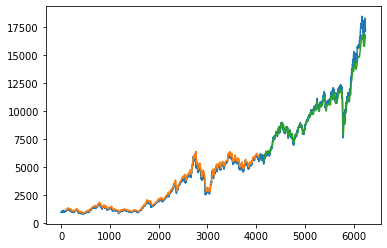

In [26]:
### Plotting 
# for 15 epoch
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

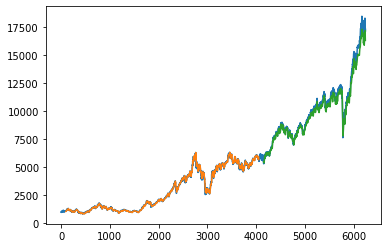

In [32]:
### Plotting 
# for 20 epoch
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

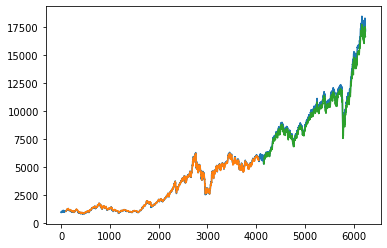

In [40]:
### Plotting 
# for 30 epoch
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

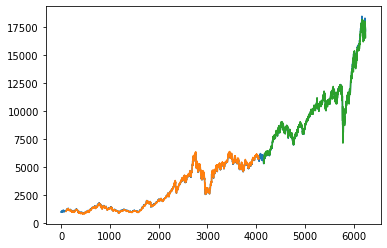

In [46]:
### Plotting 
# for 40 epoch
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()